In [71]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os

cwd = os.getcwd()
history_path = os.path.abspath(os.path.join(cwd, '..', 'history'))
# Grab the data from the DB. Paths with ~ will break this.
dbAbsolutePath = os.path.join(history_path, 'gdax_0.1.db')
conn = sqlite3.connect(dbAbsolutePath)
query = 'select * from candles_USD_BTC'
minutely_candles = pd.read_sql_query(query, conn)

minutely_candles.dropna()
print(minutely_candles.head())

   id       start      open      high       low     close           vwp  \
0   1  1512535020  12221.90  12221.90  12213.33  12219.82  12219.090523   
1   3  1512535080  12219.82  12219.82  12212.04  12219.63  12219.049882   
2   5  1512535140  12219.62  12219.62  12214.28  12216.67  12216.870828   
3   7  1512535200  12216.67  12216.68  12216.51  12216.52  12216.660592   
4   9  1512535260  12216.52  12216.52  12212.04  12212.05  12213.151112   

      volume  trades  
0  18.704906      92  
1  12.386150      86  
2   8.060148      61  
3  19.597871      53  
4  13.220658      53  


In [72]:
# Add some features
minutely_candles['timestamp'] = minutely_candles['start'].apply(lambda ts: datetime.datetime.fromtimestamp(ts))
#minutely_candles['timestamp_str'] = minutely_candles['timestamp'].apply(lambda dt: dt.strftime('%Y-%m-%d %H:%M:%S'))
minutely_candles['totalMillions'] = (minutely_candles['vwp'] * minutely_candles['trades']) / 1000000
minutely_candles = minutely_candles.drop(columns=['id', 'start'])
minutely_candles.sort_values('timestamp', inplace=True)
print(minutely_candles.head())

       open      high       low     close           vwp     volume  trades  \
0  12221.90  12221.90  12213.33  12219.82  12219.090523  18.704906      92   
1  12219.82  12219.82  12212.04  12219.63  12219.049882  12.386150      86   
2  12219.62  12219.62  12214.28  12216.67  12216.870828   8.060148      61   
3  12216.67  12216.68  12216.51  12216.52  12216.660592  19.597871      53   
4  12216.52  12216.52  12212.04  12212.05  12213.151112  13.220658      53   

            timestamp  totalMillions  
0 2017-12-05 20:37:00       1.124156  
1 2017-12-05 20:38:00       1.050838  
2 2017-12-05 20:39:00       0.745229  
3 2017-12-05 20:40:00       0.647483  
4 2017-12-05 20:41:00       0.647297  


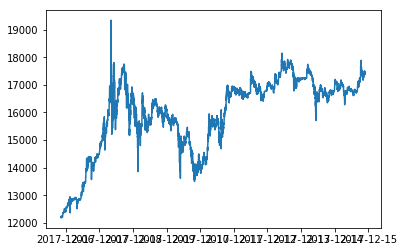

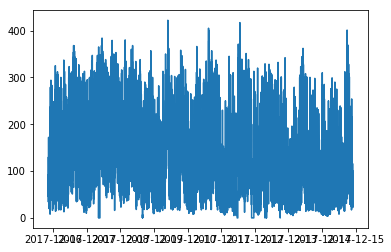

In [73]:
# Noisy as fro, yo, need to aggregate
plt.plot(minutely_candles['timestamp'], minutely_candles['vwp'])
plt.show()

plt.plot(minutely_candles['timestamp'], minutely_candles['trades'])
plt.show()

In [81]:
# Aggregate to hourly level
hourly_candles = minutely_candles.copy()
# Truncate timestamp to hour
hourly_candles['timestamp'] = hourly_candles['timestamp'].transform(lambda ts: ts.replace(microsecond=0,second=0,minute=0))
#minutely_candles['timestamp_str'] = hourly_candles['timestamp'].apply(lambda dt: dt.strftime('%Y-%m-%d %H:%M:%S'))
# TODO: Open/Close aggregation
hourly_candles = hourly_candles.groupby('timestamp').agg({'high': max,
                                                          'low': min,
                                                          'open': lambda x: x.iloc[0],
                                                          'close': lambda x: x.iloc[-1],
                                                          'volume': sum,
                                                          'trades': sum})

hourly_candles.reset_index(level=0, inplace=True)
print(hourly_candles.head())

            timestamp      open     close      high  trades       low  \
0 2017-12-05 20:00:00  12221.90  12239.99  12242.38    2106  12181.00   
1 2017-12-05 21:00:00  12239.99  12299.99  12300.00    4305  12204.01   
2 2017-12-05 22:00:00  12300.00  12450.00  12450.00    7423  12299.99   
3 2017-12-05 23:00:00  12450.00  12429.00  12540.00    7116  12354.99   
4 2017-12-06 00:00:00  12429.01  12560.00  12589.55    5815  12410.87   

        volume  
0   579.278257  
1   904.074417  
2  1404.897005  
3  1565.328071  
4  1020.887975  


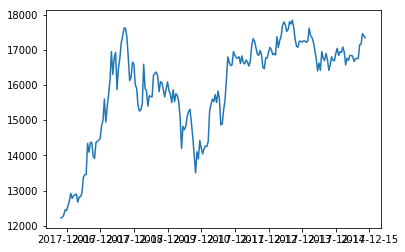

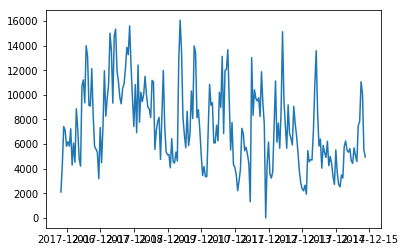

In [82]:
# Let's try plotting again
plt.plot(hourly_candles['timestamp'], hourly_candles['open'])
plt.show()

plt.plot(hourly_candles['timestamp'], hourly_candles['trades'])
plt.show()